# Packages & Lyrics file

In [7]:
! pip install --quiet deepcut

In [8]:
import numpy as np
import deepcut

from tensorflow import keras
from tensorflow.keras import layers, callbacks, utils, models

import matplotlib.pyplot as plt
from IPython.display import clear_output

import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import pickle as p

In [9]:
with open('lyrics.txt') as file:
    corpus = file.read().splitlines()  # Read text in list of lines
    
print(len(corpus))  # Numbers of line

218


# Bag of words by Tokenize w/ deepcut

In [10]:
words = []
for sentences in corpus:
    tokens = deepcut.tokenize(sentences.strip())
    for word in tokens:
        words.append(word)

In [11]:
unique_words = set(words)
print(len(unique_words))

549


In [12]:
## Cleaning non-word

print(list(sorted(unique_words)))

['', ' ', ' วณิพกพเนจร', ' เออ', ' เออ เอิงเอย', ' แพะ', '.', '......', 'กรมประชาสงเคราะห์', 'กระจก', 'กระทำ', 'กราบเรียน', 'กรุง', 'กลับ', 'กลาดเกลื่อน', 'กลาย', 'กล่อม', 'กว่า', 'กัด', 'กัน', 'กับ', 'การ', 'กำลัง', 'กิน', 'ก็', 'ก่อน', 'ขน', 'ขวบ', 'ขวัญ', 'ขอ', 'ของ', 'ขัน', 'ขับ', 'ขาด', 'ขาย', 'ข้า', 'ข้าง', 'ข้าวของเครื่องใช้', 'ขํา', 'คง', 'คน', 'ครับ', 'คราว', 'คลองแสนแสบ', 'คลอเคลีย', 'คลาดเคลื่อน', 'คลาน', 'ควร', 'ความ', 'ควาย', 'คว้า', 'คอก', 'คอย', 'คัน', 'คาบ', 'คำนึง', 'คิด', 'คิดคํา', 'คืน', 'คือ', 'คุก', 'คุณคุณ', 'คู่', 'ค่อย', 'ค่า', 'ค้า', 'ค้าของ', 'งาน', 'งาม', 'งี้', 'จงเห็นใจ', 'จน', 'จบ', 'จริง', 'จริงจัง', 'จริงใจ', 'จะ', 'จับ', 'จาก', 'จำเป็น', 'จิตใจ', 'จิ้งหรีด', 'จึง', 'จุดหมาย', 'จ้าง', 'จํา', 'ฉัน', 'ฉาย', 'ชน', 'ชอบ', 'ชัก', 'ชักชวน', 'ชั่วขอ', 'ชาย', 'ชาว', 'ชำระ', 'ชีวิต', 'ชีวิตไทย', 'ชีวิทยาทาน', 'ช่วย', 'ช่าง', 'ช้า', 'ชํ้า', 'ซื้อ', 'ดวงใจ', 'ดอก', 'ดอกเบี้ย', 'ดัง', 'ดาวน์', 'ดินดี', 'ดี', 'ดู', 'ด้วย', 'ตก', 'ตกระกำ', 'ตน', 'ตรอก', 'ตลาด', 'ตอกย้

In [13]:
## Finding non-word

print("''")
print([i for i in unique_words if i == ''])
print("\n'.'")
print([i for i in unique_words if '.' in i])
print("\n'…'")
print([i for i in unique_words if '…' in i])
print("\n'ๆ'")
print([i for i in unique_words if 'ๆ' in i])
print("\n' '")
print([i for i in unique_words if ' ' in i])

''
['']

'.'
['.', '......', '….']

'…'
['….', '…']

'ๆ'
['ๆ']

' '
['มา หา', ' ', ' เออ เอิงเอย', ' แพะ', ' วณิพกพเนจร', ' เออ', 'สรร ปัญญา', 'ประ ชา']


In [14]:
## Remove non-word

remove_space = {i.replace(' ', '') for i in unique_words}
remove_char = {i for i in remove_space
                if i == ''
                or '.' in i
                or '…' in i
                or 'ๆ' in i}
clean_words = remove_space - remove_char
# clean_words

In [15]:
len(clean_words)

539

In [16]:
vocab_size = len(clean_words)

word2int = {}
int2word = {}

for i, word in enumerate(clean_words):
    word2int[word] = i
    int2word[i] = word

# word2int
# int2word

# Prepare Sentence

In [17]:
sentences = []
for st in corpus:
    tokens = deepcut.tokenize(st.strip())
    sentences.append(tokens)
# sentences

In [18]:
## Remove non-word
remove_space_sentences = [[i.replace(' ', '') for i in st]
                          for st in sentences]  # Remove space
remove_empty_word = [[i for i in st if i != ''] for st in remove_space_sentences]
clean_sentences = [[i for i in st
                    if '.' not in i
                    and '…' not in i
                    and 'ๆ' not in i]
                   for st in remove_empty_word if st]
# clean_sentences

# Use 2-Gram

In [19]:
WINDOW_SIZE = 2

data = []
for sentence in clean_sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence))+1] : 
            if nb_word != word:
                data.append([word, nb_word])      
data[:10]

[['ถึง', 'ยากจน'],
 ['ถึง', 'ไม่'],
 ['ยากจน', 'ถึง'],
 ['ยากจน', 'ไม่'],
 ['ยากจน', 'มอง'],
 ['ไม่', 'ถึง'],
 ['ไม่', 'ยากจน'],
 ['ไม่', 'มอง'],
 ['ไม่', 'คน'],
 ['มอง', 'ยากจน']]

In [20]:
len(data)

4560

# Create dataset

In [21]:
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

x_train = [] # input word
y_train = [] # output word
for data_word in data:
    x_train.append(to_one_hot(word2int[ data_word[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ data_word[1] ], vocab_size))

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_train.shape, y_train.shape

((4560, 539), (4560, 539))

In [22]:
# x_train
# y_train

# Create Model

In [23]:
filename = 'w2v.h5'
checkpoint = callbacks.ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [24]:
model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[vocab_size]),
    layers.Dropout(0.25),
    layers.Dense(vocab_size, activation = 'softmax')
])

In [25]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               54000     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 539)               54439     
Total params: 108,439
Trainable params: 108,439
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.optimizer.learning_rate = 0.0003

In [28]:
class PlotLosses(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

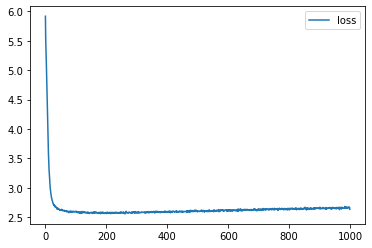

In [29]:
history = model.fit(
    x_train,
    y_train,
    batch_size = 1,
    epochs=1000,
    verbose=1,
    callbacks = [checkpoint, plot_losses])

In [30]:
import pandas as pd

In [31]:
pd.Series(history.history['loss'])

0      5.916597
1      5.504388
2      5.327101
3      5.127540
4      4.896288
         ...   
995    2.669380
996    2.662617
997    2.659957
998    2.673445
999    2.636189
Length: 1000, dtype: float64

In [32]:
pd.Series(history.history['loss']).idxmin()

261

In [33]:
pd.Series(history.history['loss']).min()

2.5576364994049072

# Load model from checkpoint

In [34]:
checkpoint_model = models.load_model(filename)

In [35]:
wb1 = checkpoint_model.layers[0].get_weights()
wb1[0].shape, wb1[1].shape

((539, 100), (100,))

In [36]:
w1 = wb1[0]
b1 = wb1[1]

vectors = w1 + b1

vectors.shape

(539, 100)

In [37]:
with open('w2v_history_model', 'wb') as file:
    p.dump(history.history, file)

In [38]:
## Use to load history of model training

# with open('w2v_history_model', 'rb') as file:
#      his = p.load(file)

# Testing calculate w/ euclidean distance

In [39]:
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def find_closest(word_index, vectors):
    min_dist = 10000 
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

In [40]:
print(int2word[find_closest(word2int['ฟ้า'], vectors)])
print(int2word[find_closest(word2int['จน'], vectors)])
print(int2word[find_closest(word2int['ยาก'], vectors)])

ฝนฉํ่า
ไหร่
ก่อน


# Export file to plot in https://projector.tensorflow.org/

In [42]:
import csv

with open('w2v.tsv', 'w') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    for v in vectors:
        tsv_writer.writerow(v)
        
with open('label.tsv', 'w') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    for word in word2int:  
        tsv_writer.writerow([word])